In [49]:
from IPython.display import display, HTML, Markdown
import pandas as pd
import toml
import sys
import os
from pycaret.regression import *
from sklearn.impute import KNNImputer
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from patsy import dmatrices
import matplotlib.pyplot as plt
import graphviz as gr
import numpy as np
from lightgbm import LGBMRegressor
from sklearn.metrics import r2_score


In [ ]:
# Change the working directory to the root of the project
while os.path.basename(cwd := os.getcwd()) != "profitability_of_discounts":
    print(cwd)
    os.chdir("..")

# Load the configuration
config = toml.load("config.toml")

# Add the source folder to the path
sys.path.append("./causality")
from data import load_data

# If the file does not exists download it
if not os.path.exists(config["path"]["filename"]):
    data_raw = load_data(config=config)

In [24]:
# Check if the file exists
# destiny_file = f"{config["path"]["data_raw"]}/{config["path"]["filename"]}"
# Load the data
train = pd.read_parquet("data/raw/non_rand_discount.parquet")
train.sample(5)

,spend_1m_baby,spend_2m_baby,spend_3m_baby,spend_4m_baby,spend_5m_baby,spend_6m_baby,spend_1m_clothes,spend_2m_clothes,spend_3m_clothes,spend_4m_clothes,...,spend_6m_eletronic,sales,discount,profit,age,gender,cust_state,tenure,sales_prediction_bins,sales_prediction
6525,0,0,0,0,0,0.0,0,0.0,0.0,0.0,...,0.0,2839.44,US$ 90.0,49.13,42,NaN,SC,4,5,1098.404560
1091,0,0,0,0,0,0.0,0,0.0,0.0,0.0,...,0.0,1878.51,US$ 50.0,42.05,30,0.0,CE,6,1,946.251682
2400,0,0,0,0,0,0.0,0,0.0,0.0,0.0,...,0.0,2615.16,US$ 110.0,18.14,36,0.0,PE,5,7,1217.764107
6512,0,0,0,0,0,0.0,0,0.0,0.0,0.0,...,0.0,1262.14,US$ 30.0,31.84,25,1.0,SP,7,0,865.769174
12013,0,0,0,0,0,0.0,0,0.0,0.0,0.0,...,0.0,1937.88,US$ 60.0,34.96,28,1.0,DF,4,4,1032.397156


In [25]:
train.describe()

,spend_1m_baby,spend_2m_baby,spend_3m_baby,spend_4m_baby,spend_5m_baby,spend_6m_baby,spend_1m_clothes,spend_2m_clothes,spend_3m_clothes,spend_4m_clothes,...,spend_4m_eletronic,spend_5m_eletronic,spend_6m_eletronic,sales,profit,age,gender,tenure,sales_prediction_bins,sales_prediction
count,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,...,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,13525.000000,15000.000000,15000.000000,15000.000000
mean,0.766000,0.460667,0.469667,0.512000,0.482000,22.075667,3.966667,9.124667,9.605333,10.158667,...,3.690000,3.403333,3.853333,2509.492502,45.200751,31.405133,0.505656,6.006667,4.499800,1127.639680
std,2.104805,2.532761,2.485590,2.853956,2.682938,166.373431,10.767542,52.001546,54.000821,55.195512,...,70.963979,60.474467,67.174792,1078.895564,23.353833,6.269037,0.499986,2.440591,2.872516,279.903254
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,528.240000,-17.650000,16.000000,0.000000,0.000000,0.000000,751.202972
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1658.242500,32.570000,27.000000,0.000000,4.000000,2.000000,968.474340
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,2316.855000,41.180000,31.000000,1.000000,6.000000,4.500000,1071.984319
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,3298.507500,52.020000,35.000000,1.000000,8.000000,7.000000,1211.290946
max,20.000000,60.000000,70.000000,80.000000,70.000000,1650.000000,125.000000,600.000000,555.000000,525.000000,...,4000.000000,2000.000000,2500.000000,10758.200000,492.150000,65.000000,1.000000,18.000000,9.000000,4924.383596


In [26]:
data_raw['spend_1m_baby'].plot(kind='hist')

TypeError: 'NoneType' object is not subscriptable

In [10]:
test = pd.read_csv("data/raw/random_data.csv")
test.sample(5)

,spend_1m_baby,spend_2m_baby,spend_3m_baby,spend_4m_baby,spend_5m_baby,spend_6m_baby,spend_1m_clothes,spend_2m_clothes,spend_3m_clothes,spend_4m_clothes,...,spend_4m_eletronic,spend_5m_eletronic,spend_6m_eletronic,sales,discount,age,gender,cust_state,tenure,profit
4057,0,0,0,0,0,0.0,0,0.0,0.0,0.0,...,0.0,0.0,0.0,1191.29,10.0,26,0.0,SE,21,49.56
3620,0,0,0,0,0,0.0,25,0.0,25.0,25.0,...,0.0,0.0,0.0,1254.11,10.0,26,NaN,MA,21,52.71
4103,0,0,0,0,0,0.0,0,0.0,0.0,0.0,...,0.0,0.0,0.0,1549.79,10.0,26,0.0,MG,20,67.49
4506,0,0,0,0,0,0.0,0,0.0,0.0,0.0,...,0.0,0.0,0.0,1065.95,0.0,35,1.0,MG,18,53.30
2928,0,0,0,0,0,0.0,0,0.0,0.0,0.0,...,0.0,0.0,0.0,1074.07,0.0,29,1.0,SP,21,53.70


In [14]:
set(train.columns).symmetric_difference(set(test.columns))

{'sales_prediction', 'sales_prediction_bins'}

In [15]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 43 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   spend_1m_baby       5000 non-null   int64  
 1   spend_2m_baby       5000 non-null   int64  
 2   spend_3m_baby       5000 non-null   int64  
 3   spend_4m_baby       5000 non-null   int64  
 4   spend_5m_baby       5000 non-null   int64  
 5   spend_6m_baby       5000 non-null   float64
 6   spend_1m_clothes    5000 non-null   int64  
 7   spend_2m_clothes    5000 non-null   float64
 8   spend_3m_clothes    5000 non-null   float64
 9   spend_4m_clothes    5000 non-null   float64
 10  spend_5m_clothes    5000 non-null   float64
 11  spend_6m_clothes    5000 non-null   float64
 12  spend_1m_health     5000 non-null   int64  
 13  spend_2m_health     5000 non-null   int64  
 14  spend_3m_health     5000 non-null   int64  
 15  spend_4m_health     5000 non-null   int64  
 16  spend_

In [17]:
train.shape, test.shape

((15000, 45), (5000, 43))

In [21]:
train["discount"]

0        125.0
1         75.0
2         50.0
3         10.0
4        100.0
         ...  
14995    110.0
14996    135.0
14997      0.0
14998    145.0
14999     30.0
Name: discount, Length: 15000, dtype: float64

In [22]:
train["discount"] = train["discount"].str.split(" ").str[-1].astype(float)

AttributeError: Can only use .str accessor with string values!

UFuncTypeError: ufunc 'multiply' did not contain a loop with signature matching types (dtype('<U7'), dtype('float64')) -> None

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

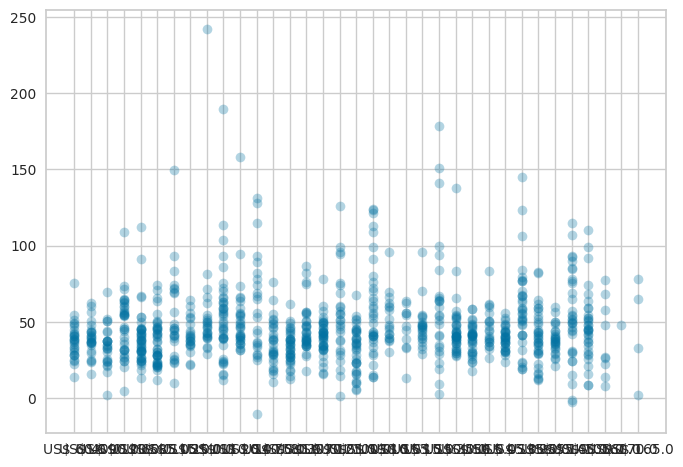

In [29]:
sns.regplot(data = train.sample(1000), x="discount", y="profit", scatter_kws={"alpha":0.3})

<Axes: xlabel='discount', ylabel='profit'>

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

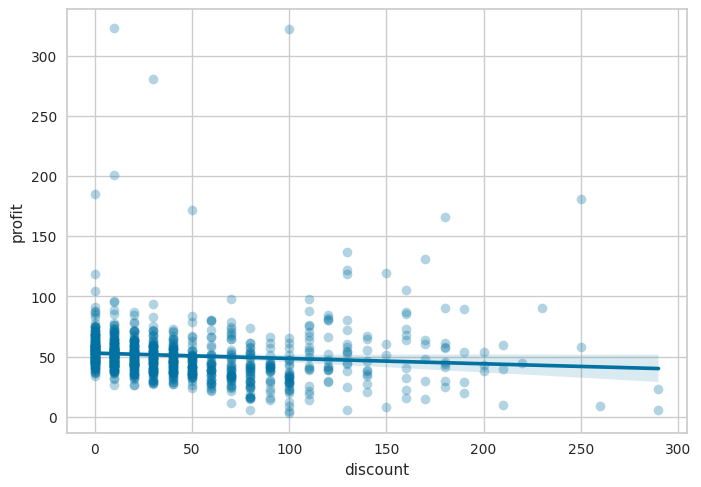

In [28]:
sns.regplot(data = test.sample(1000), x="discount", y="profit", scatter_kws={"alpha":0.3})

In [56]:
smf.ols("profit~discount", data=test).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,51.3226,0.390,131.725,0.000,50.559,52.086
discount,-0.0357,0.006,-6.058,0.000,-0.047,-0.024


In [33]:
def elast(data, t, y):
    cov_matrix = np.cov(data[y], data[t])
    return cov_matrix[1, 0] / cov_matrix[1, 1]

In [42]:
# efecto promedio del tratamiento
print("ATE del descuento sobre el beneficio:", elast(test, "discount", "profit"))
print("ATE del descuento sobre las ventas:", elast(test, "discount", "sales"))

ATE del descuento sobre el beneficio: -0.03566112670736013
ATE del descuento sobre las ventas: 19.286765416028715


In [41]:
print("Relacion entre descuento y ventas:", elast(train, "discount", "sales"))
print("Relacion entre descuento y ganancias:", elast(train, "discount", "profit"))

Relacion entre descuento y ventas: 21.924806313467585
Relacion entre descuento y ganancias: 0.07431475005627178


In [39]:
train["discount"] = train["discount"].str.split(" ").str[-1].astype(float)

In [40]:
train[['discount', 'sales','profit']]

,discount,sales,profit
0,125.0,3368.64,40.06
1,75.0,2133.10,29.52
2,50.0,2001.62,48.08
3,10.0,1461.96,61.64
4,100.0,2743.72,34.44
...,...,...,...
14995,110.0,4440.30,107.57
14996,135.0,3009.38,12.46
14997,0.0,881.77,43.21
14998,145.0,4385.49,69.89


In [43]:
X = list(train.drop(columns=['sales', 'profit', "cust_state", "discount", "sales_prediction_bins", "sales_prediction"]).columns)
Y = "sales"

In [44]:
X

['spend_1m_baby',
 'spend_2m_baby',
 'spend_3m_baby',
 'spend_4m_baby',
 'spend_5m_baby',
 'spend_6m_baby',
 'spend_1m_clothes',
 'spend_2m_clothes',
 'spend_3m_clothes',
 'spend_4m_clothes',
 'spend_5m_clothes',
 'spend_6m_clothes',
 'spend_1m_health',
 'spend_2m_health',
 'spend_3m_health',
 'spend_4m_health',
 'spend_5m_health',
 'spend_6m_health',
 'spend_1m_pet',
 'spend_2m_pet',
 'spend_3m_pet',
 'spend_4m_pet',
 'spend_5m_pet',
 'spend_6m_pet',
 'spend_1m_groceries',
 'spend_2m_groceries',
 'spend_3m_groceries',
 'spend_4m_groceries',
 'spend_5m_groceries',
 'spend_6m_groceries',
 'spend_1m_eletronic',
 'spend_2m_eletronic',
 'spend_3m_eletronic',
 'spend_4m_eletronic',
 'spend_5m_eletronic',
 'spend_6m_eletronic',
 'age',
 'gender',
 'tenure']

In [46]:
np.random.seed(123)
pred_m = LGBMRegressor(max_depth=3)
pred_m.fit(train[X], train[Y])

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001465 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 804
[LightGBM] [Info] Number of data points in the train set: 15000, number of used features: 39
[LightGBM] [Info] Start training from score 2509.492501
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

LGBMRegressor(max_depth=3)

In [47]:
train_pred = train.assign(prediction = pred_m.predict(train[X])) 
test_pred = test.assign(prediction = pred_m.predict(test[X]))

In [50]:
print("Train Score:", r2_score(train_pred["sales"], train_pred["prediction"]))
print("Test Score:", r2_score(test_pred["sales"], test_pred["prediction"]))

Train Score: 0.8542367421768512
Test Score: 0.42184459036355626


In [51]:
sorted_by_pred_test = test_pred.sort_values("prediction", ascending=False)

In [52]:
sorted_by_pred_test[["prediction", "profit", "discount"]].head()

,prediction,profit,discount
2913,8410.140425,389.76,150.0
1736,7171.388857,295.87,300.0
646,6496.265942,322.49,10.0
4354,6404.367544,186.96,180.0
1689,6375.683350,165.58,180.0


In [53]:
print("CATE top 1k:", elast(sorted_by_pred_test.head(1000), "discount", "profit"))
print("CATE botom 1k:", elast(sorted_by_pred_test.tail(1000), "discount", "profit"))

CATE top 1k: -0.09637736244794491
CATE botom 1k: -0.29111205551220626


Parte 3

In [57]:
test_pred["binary_discount"] = np.where(test_pred["discount"] > 30, 1, 0)

In [58]:
test_pred["binary_discount"] 

0       0
1       1
2       0
3       0
4       0
       ..
4995    0
4996    0
4997    0
4998    1
4999    0
Name: binary_discount, Length: 5000, dtype: int64

In [59]:
def te(df, t, y):
    return df.query(f"{t}==1")[y].mean() - df.query(f"{t}==0")[y].mean()

ate = te(test_pred, y="profit", t="binary_discount")
ate

-7.955100647304356

In [60]:
def te_por_segmento(df, pred, t, y, segments=10):
    return (df
            .assign(**{f"{pred}_band":pd.qcut(df[pred], q=segments)})
            .groupby(f"{pred}_band")
            .apply(lambda df: te(df, y=y, t=t)))

In [61]:
te_por_segmento(test_pred, "prediction", y="profit", t="binary_discount", segments=10)

prediction_band
(1183.2830000000001, 1465.021]   -14.589034
(1465.021, 1582.582]             -14.233836
(1582.582, 1724.919]             -13.511043
(1724.919, 1915.046]             -11.954802
(1915.046, 2119.377]             -12.778500
(2119.377, 2292.789]             -11.474989
(2292.789, 2488.099]              -9.816529
(2488.099, 2669.861]              -9.593673
(2669.861, 3188.301]             -19.859046
(3188.301, 8410.14]              -29.444937
dtype: float64

In [62]:
te_por_segmento(test_pred.assign(rnd=np.random.uniform(0,1,test.shape[0])),
               "rnd", y="profit", t="binary_discount", segments=10)

rnd_band
(-0.0009322, 0.0959]   -6.234814
(0.0959, 0.195]        -8.543122
(0.195, 0.294]         -6.765285
(0.294, 0.399]         -9.053745
(0.399, 0.502]         -6.591192
(0.502, 0.6]           -9.149355
(0.6, 0.7]             -7.340231
(0.7, 0.799]           -9.466891
(0.799, 0.898]         -9.288254
(0.898, 1.0]           -7.335161
dtype: float64

In [64]:
te_por_segmento(test_pred.assign(rnd=np.random.uniform(0,1,test.shape[0])),
               "rnd", y="profit", t="binary_discount", segments=10)

rnd_band
(-0.000875, 0.106]    -7.603185
(0.106, 0.194]        -4.266228
(0.194, 0.296]        -7.704285
(0.296, 0.402]        -8.046289
(0.402, 0.505]        -9.353739
(0.505, 0.604]        -7.320078
(0.604, 0.701]       -10.424084
(0.701, 0.793]        -5.454146
(0.793, 0.893]       -10.492232
(0.893, 0.999]        -9.403555
dtype: float64

<Axes: title={'center': 'Profit-Discount Effect by Age Band'}, xlabel='age_band'>

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

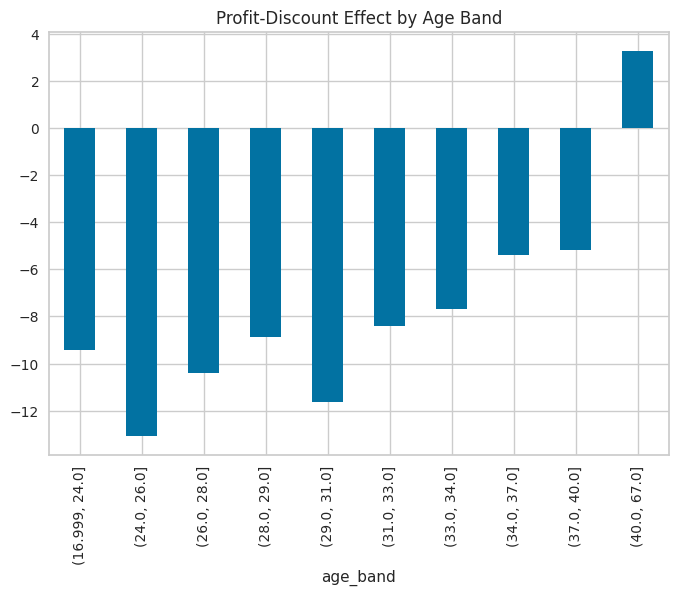

In [67]:
te_por_segmento(test_pred, "age", y="profit", t="binary_discount", segments=10).plot.bar(title="Profit-Discount Effect by Age Band")